In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

from tools_fast import make_track, ols_regression, make_ER, lasso_regression, lasso_regression_ic, ridge_regression, \
    kalman_filter, kalman_with_selection, selective_kalman_filter, replication_stats, ml_kalman_filter, \
    ml_kalman_filter2
from clustering import cluster, cluster_net
from hc_graph import hc_stock, hc_piechart, hc_spiderweb

<IPython.core.display.Javascript object>

Open console to check js libs were loaded in page


In [3]:
fund_name = 'HFRXGL'
pd.read_csv(r"financial_data/hfrx_index_names.csv", index_col=0)

,Full Name
Name,
HFRXAR,HFRX Absolute Return Index
HFRXDS,HFRX ED: Distressed Restructuring Index
HFRXMA,HFRX ED: Merger Arbitrage Index
HFRXSS,HFRX ED: Special Situations Index
HFRXEMN,HFRX EH: Equity Market Neutral Index
HFRXEHG,HFRX EH: Fundamental Growth Index
HFRXEHV,HFRX EH: Fundamental Value Index
HFRXEMC,HFRX Emerging Markets Composite Index
HFRXEW,HFRX Equal Weighted Strategies Index


### Financial data loads and cleaning

In [4]:
# US rate
US_rate = pd.read_csv(r"financial_data/USD_rates.csv", index_col=0, parse_dates=True, dayfirst=True)['3M']

# HFRX
hfrx_all = pd.read_csv(r"financial_data/hfrx_daily_index_data.csv", index_col=0, parse_dates=True, dayfirst=True).ffill()
hfrx = make_ER(hfrx_all[[fund_name]].dropna(), US_rate)

# BNP

bnp = pd.read_csv(r"financial_data/bnp_data.csv", index_col=0, parse_dates=True, dayfirst=True) #[["BNPIFEU","BNPIFUS",
                 #"BNPIFJP","BNPIFCN","BNPIFFR","BNPIFGE","BNPIFGB","BNPIFCH","BNPIFKR","BNPIFUSC","BNPIFBR",
                 #"BNPIFAU","BNPIFHK","BNPIFTW","BNPIFSG","BNPIFIT","BNPIFSP","BNPIFSW","BNPIFNE","BNPIFRU","BNPIFEM"]]

risk_premia = pd.read_pickle("financial_data/risk_premia_ER_FX_USD.pkl") #[["BNPICCE3","BNPIVMRU","BNPIAIRT","BNPIAIRU",
                  #"BNPIEC03","BNPIPLEE","BNPIPMEE","BNPIPQEE","BNPIPVEE","BNPILUEE","BNPIPMUH","BNPIPQUH",
                  #"BNPIPVUH","BNPIAIRG","BNPIAIRJ","BNPIAIRE"]]

In [5]:
df_info = pd.read_csv(r"financial_data/bnp_info.csv", index_col=0)
df_info.head()

,Asset Class,Style
Ticker,,
BNPIDRXA,Commodity,Carry
BNPIF3AX,Commodity,Carry
BNPIF3XM,Commodity,Momentum
BPFXSTGU,FX,Value
BNPICCE3,Equity,Carry


In [6]:
prices_all = bnp.join(risk_premia,how="inner").ffill().join(hfrx,how="inner")
prices_all.head()

,BNPIFEU,BNPIFUS,BNPIFJP,BNPIFCN,BNPIFFR,BNPIFGE,BNPIFGB,BNPIFCH,BNPIFKR,BNPIFUSC,...,BNPIPQEE,BNPIPVEE,BNPILUEE,BNPIPMUH,BNPIPQUH,BNPIPVUH,BNPIMDEA,BNPIAIFH,BNPICVXA,HFRXGL
2007-01-03,251.659037,221.446381,123.569027,122.453216,213.419777,187.351929,143.396494,295.276204,289.6684,214.633123,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,1.139312
2007-01-04,250.891929,221.752767,124.485468,116.840530,212.022884,186.812785,142.625314,294.978808,285.5191,215.297053,...,0.996090,0.995580,0.997660,1.001242,1.000243,0.996902,1.000146,NaN,NaN,1.138206
2007-01-05,247.941926,220.296431,122.435019,116.354951,210.202422,184.800752,141.220705,294.559578,283.5307,211.436575,...,1.000518,1.000001,0.996420,0.999333,0.999586,0.998485,0.989704,NaN,NaN,1.133748
2007-01-08,247.619806,220.849207,122.435019,114.489675,209.896589,184.914022,140.466947,292.889470,280.1748,211.660237,...,1.005248,1.002365,0.997761,1.000212,0.998146,0.996573,0.988449,NaN,NaN,1.132876
2007-01-09,247.980535,220.738811,123.630465,112.996176,210.556213,185.164783,140.518570,293.917702,281.4930,211.994064,...,1.005052,1.002498,0.999367,1.001821,0.995801,0.994901,0.988940,NaN,NaN,1.133340


In [7]:
returns_all = prices_all.pct_change().iloc[1:]
hrfx_returns = returns_all[[fund_name]]
returns_all = returns_all.drop(fund_name, axis=1)
prices_all = prices_all.drop(fund_name, axis=1)
prices_all = prices_all.bfill()

In [8]:
alpha = hrfx_returns[fund_name].autocorr(lag=1)
hrfx_returns_adj = ((hrfx_returns - alpha * hrfx_returns.shift(1)) / (1. - alpha)).fillna(0) # 'liquidity adjustment' for
                                                                                             # removing returns autocorrelation
beta = hrfx_returns_adj[fund_name].autocorr(lag=1)

Auto-correlation of HFRXGL returns : 0.21130542685883436
Auto-correlation of HFRXGL adjusted returns : -0.004752054621146798


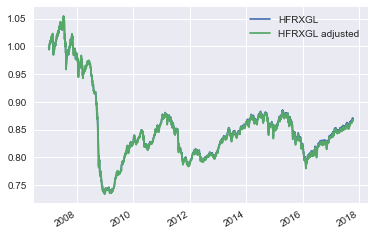

In [9]:
print("Auto-correlation of",fund_name,"returns :", alpha)
print("Auto-correlation of",fund_name,"adjusted returns :", beta)
ax = (1 + hrfx_returns).cumprod().plot()
_ = (1 + hrfx_returns_adj).cumprod()[fund_name].plot(label=fund_name + ' adjusted', legend=True, ax=ax)

## Estimation of the exposures

In [10]:
size = 126
freq = 5

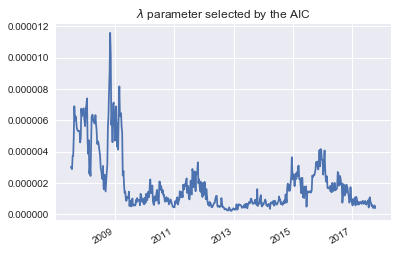

Wall time: 43.2 s


In [14]:
%%time
df_weight_aic, _ = lasso_regression_ic(hrfx_returns, returns_all,sample_length=size, frequency=freq, criterion='aic')
prices_for_track_aic = prices_all.loc[df_weight_aic.index[0]:]

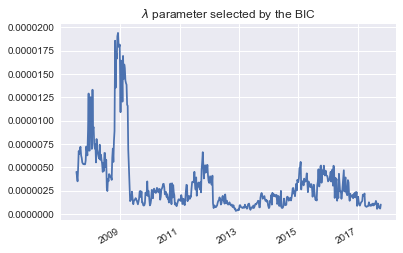

Wall time: 41.2 s


In [15]:
%%time
df_weight_bic, _ = lasso_regression_ic(hrfx_returns, returns_all,sample_length=size, frequency=freq, criterion='bic')
prices_for_track_bic = prices_all.loc[df_weight_bic.index[0]:]

In [28]:
%%time
nu = 1.0
df_weight_kalman = kalman_filter(hrfx_returns, returns_all,freq, sigma_weight=1. , sigma_return=nu)

prices_for_track_kalman = prices_all.loc[df_weight_kalman.index[0]:]

Wall time: 417 ms


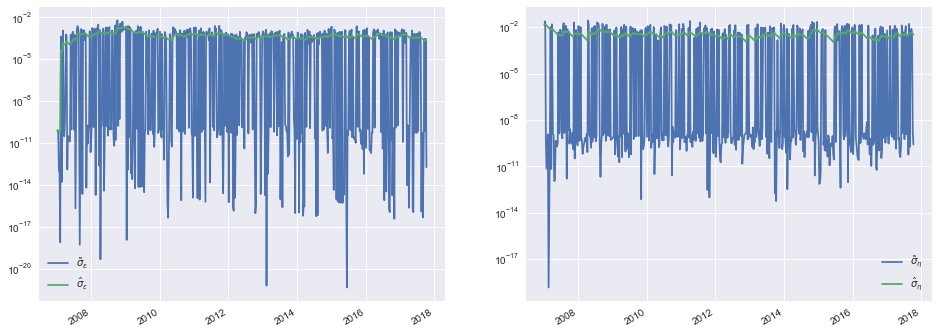

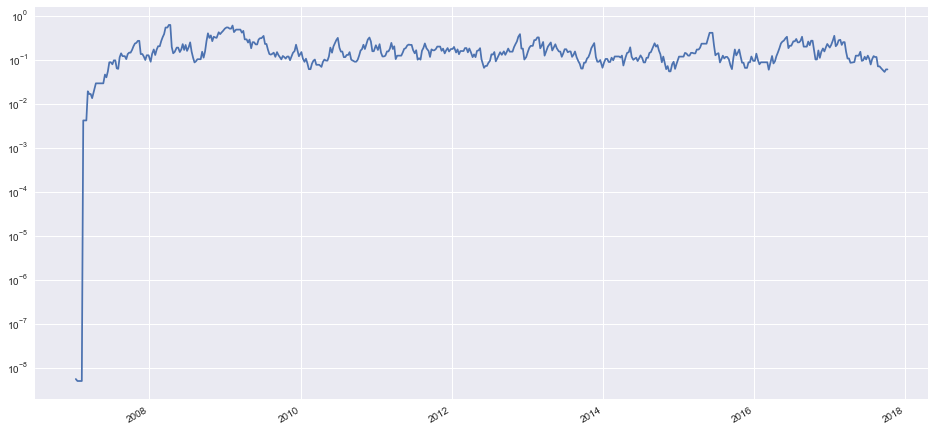

Wall time: 32.5 s


In [29]:
%%time
tau = 0.1
df_weight_ml_kalman, df_sigma = ml_kalman_filter(hrfx_returns, returns_all, freq, tau=tau, plot_sigma=True)

In [17]:
%%time
df_weight_kalman_bic = selective_kalman_filter(hrfx_returns, returns_all,sample_length=size, frequency=freq,\
                                          nu=nu, criterion='bic')

prices_for_track_kalman_bic = prices_all.loc[df_weight_kalman_bic.index[0]:]

Wall time: 43.9 s


In [18]:
%%time
df_weight_kalman_aic = selective_kalman_filter(hrfx_returns, returns_all,sample_length=size, frequency=freq,\
                                          nu=nu, criterion='aic')

prices_for_track_kalman_aic = prices_all.loc[df_weight_kalman_aic.index[0]:]

Wall time: 44.6 s


## Replication

In [30]:
%%time
tc = 0.0005
lag = 1

replication_aic = make_track(prices_for_track_aic, df_weight_aic, tc=tc, lag=lag)
df_res = hfrx.loc[replication_aic.index]
df_res["Lasso AIC"] = replication_aic

replication_bic = make_track(prices_for_track_bic, df_weight_bic, tc=tc, lag=lag)
df_res["Lasso BIC"] = replication_bic

replication_kalman = make_track(prices_for_track_kalman, df_weight_kalman, tc=tc, lag=lag).loc[df_res.index[0]:]
df_res["Kalman"] = replication_kalman

replication_ml_kalman = make_track(prices_for_track_kalman, df_weight_ml_kalman, tc=tc, lag=lag).loc[df_res.index[0]:]
df_res["ML Kalman"] = replication_ml_kalman

replication_kalman_aic = make_track(prices_for_track_kalman_aic, df_weight_kalman_aic, tc=tc, lag=lag).loc[df_res.index[0]:]
df_res["Kalman AIC"] = replication_kalman_aic

replication_kalman_bic = make_track(prices_for_track_kalman_bic, df_weight_kalman_bic, tc=tc, lag=lag).loc[df_res.index[0]:]
df_res["Kalman BIC"] = replication_kalman_bic

Wall time: 1.69 s


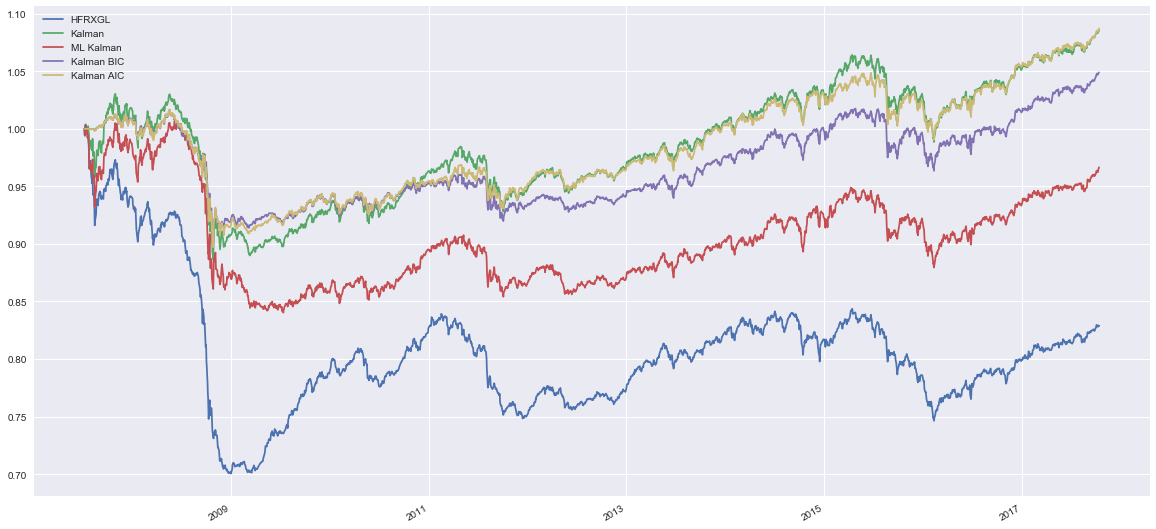

In [31]:
df_res = (df_res / df_res.iloc[0])
df_res[[fund_name, 'Kalman', 'ML Kalman', 'Kalman BIC', 'Kalman AIC']].plot(figsize=(20,10))

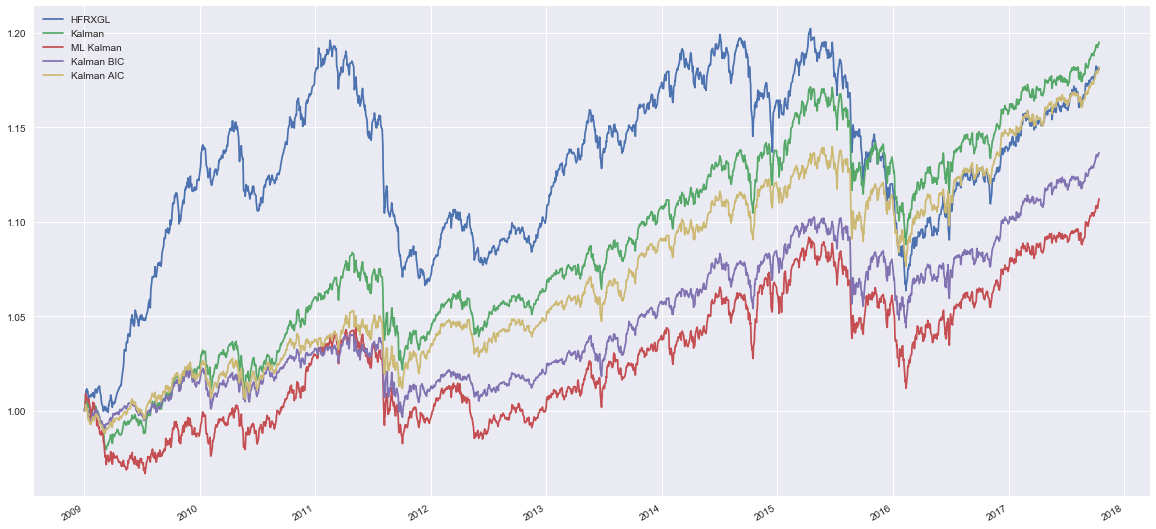

In [32]:
temp = df_res.loc['2009':]
temp = (temp / temp.iloc[0])
temp[[fund_name, 'Kalman', 'ML Kalman', 'Kalman BIC', 'Kalman AIC']].plot(figsize=(20,10))

In [33]:
df_stat = replication_stats(df_res, fund_name=fund_name)
df_stat

,Tracking error,R-squared,Sharpe ratio,Annual Return,Correlation,Kendall tau
HFRXGL,0.000000,1.000000,-0.445602,-0.018424,1.000000,1.000000
Lasso AIC,0.001475,0.656585,0.251287,0.007041,0.813429,0.608452
Lasso BIC,0.001570,0.610799,0.140649,0.003231,0.799653,0.592683
Kalman,0.001389,0.695168,0.239680,0.008182,0.838078,0.629377
ML Kalman,0.001592,0.599868,-0.061964,-0.003359,0.804615,0.580179
Kalman AIC,0.001569,0.611012,0.272141,0.008313,0.782258,0.597067
Kalman BIC,0.001619,0.586231,0.167072,0.004748,0.765959,0.570648


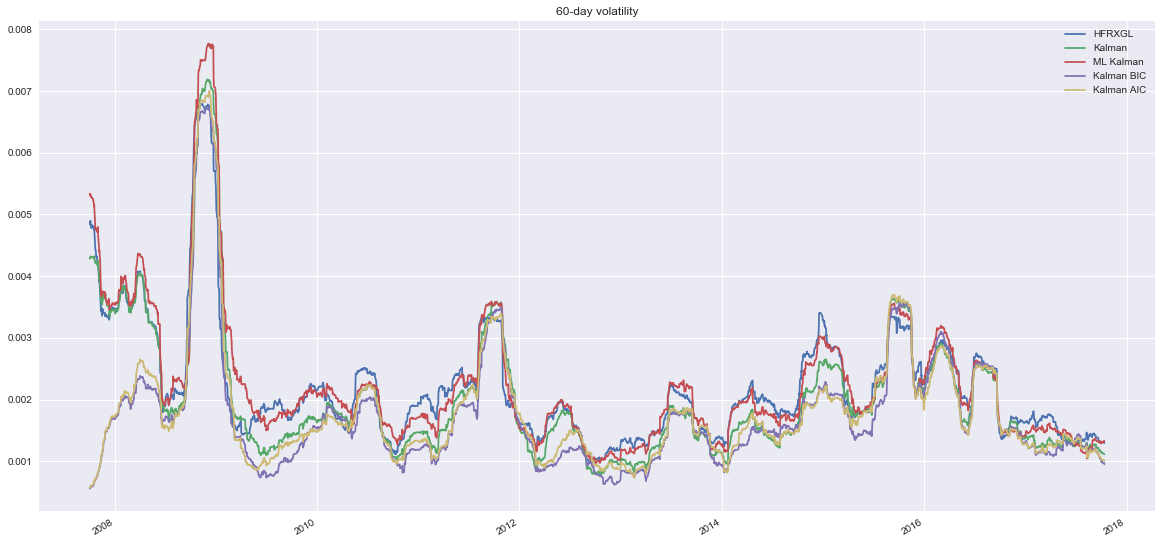

In [34]:
vol = df_res.pct_change().rolling(window=60).std().dropna()
vol[[fund_name, 'Kalman', 'ML Kalman', 'Kalman BIC', 'Kalman AIC']].plot(figsize=(20,10), title='60-day volatility')

### Volatility adjustment

In [35]:
%%time
df_weight_kalman_aic_voladj = selective_kalman_filter(hrfx_returns, returns_all,sample_length=size, frequency=freq,\
                                          nu=nu, criterion='aic', vol_target=True)
df_weight_kalman_bic_voladj = selective_kalman_filter(hrfx_returns, returns_all,sample_length=size, frequency=freq,\
                                          nu=nu, criterion='bic', vol_target=True)
df_weight_kalman_voladj = kalman_filter(hrfx_returns, returns_all,freq, sigma_weight=1. , sigma_return=nu, vol_target=True)
df_weight_ml_kalman_voladj, _ = ml_kalman_filter(hrfx_returns, returns_all,freq, tau=tau, vol_target=True)

prices_for_track = prices_all.loc[df_weight_kalman_aic_voladj.index[0]:]

replication_kalman_aic_voladj = make_track(prices_for_track, df_weight_kalman_aic_voladj, tc=tc, lag=lag)
df_res_voladj = hfrx.loc[replication_kalman_aic_voladj.index]
df_res_voladj["Kalman AIC"] = replication_kalman_aic_voladj

replication_kalman_bic_voladj = make_track(prices_for_track, df_weight_kalman_bic_voladj, tc=tc, lag=lag)
df_res_voladj["Kalman BIC"] = replication_kalman_bic_voladj

prices_for_track = prices_all.loc[df_weight_kalman_voladj.index[0]:]

replication_kalman_voladj = make_track(prices_for_track, df_weight_kalman_voladj, tc=tc, lag=lag)
df_res_voladj["Kalman"] = replication_kalman_voladj

replication_ml_kalman_voladj = make_track(prices_for_track, df_weight_ml_kalman_voladj, tc=tc, lag=lag)
df_res_voladj["ML Kalman"] = replication_ml_kalman_voladj

Wall time: 1min 56s


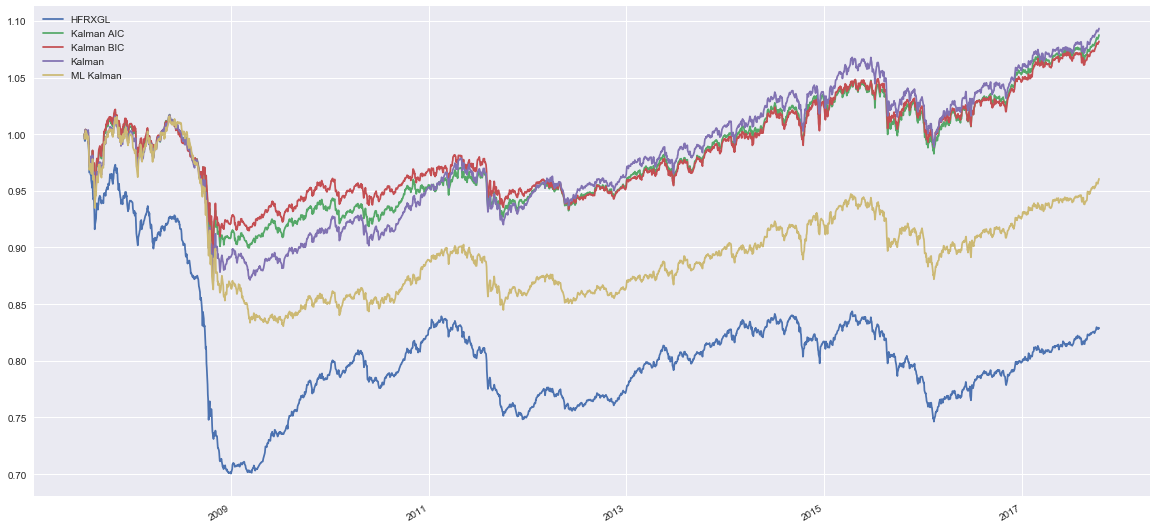

In [36]:
df_res_voladj = df_res_voladj.bfill()
df_res_voladj = (df_res_voladj / df_res_voladj.iloc[0])
df_res_voladj.plot(figsize=(20,10))

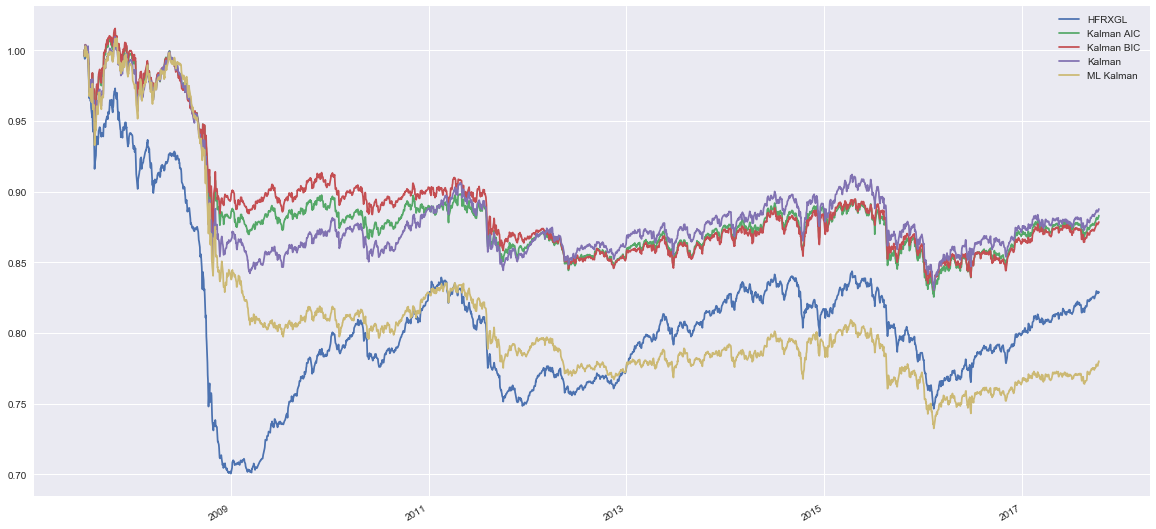

In [37]:
df_res_volperfadj = df_res_voladj[[fund_name]].copy()
temp = df_res_voladj.drop(fund_name, axis=1)
df_res_volperfadj[temp.columns]= make_ER(temp, 2 + 0 * US_rate)
df_res_volperfadj.plot(figsize=(20,10))

## Statistics on replication

In [38]:
df_stat_vol = replication_stats(df_res_voladj, fund_name=fund_name)
df_stat_vol

,Tracking error,R-squared,Sharpe ratio,Annual Return,Correlation,Kendall tau
HFRXGL,0.000000,1.000000,-0.445602,-0.018424,1.000000,1.000000
Kalman AIC,0.001487,0.650744,0.229159,0.008346,0.824485,0.613635
Kalman BIC,0.001548,0.621327,0.217261,0.007831,0.808682,0.590126
Kalman,0.001434,0.675115,0.237969,0.008875,0.840397,0.629868
ML Kalman,0.001642,0.574075,-0.072221,-0.003970,0.802110,0.581069


## Volatility contributions

In [ ]:
df_vol_contrib_kalman_voladj = (prices_all.reindex(df_weight_kalman_voladj.index).pct_change()*df_weight_kalman_voladj).std()
df_vol_contrib_kalman_voladj = df_vol_contrib_kalman_voladj/df_vol_contrib_kalman_voladj.sum()

df_vol_contrib_kalman_bic_voladj = (prices_all.reindex(df_weight_kalman_bic_voladj.index).pct_change()*df_weight_kalman_bic_voladj).std()
df_vol_contrib_kalman_bic_voladj = df_vol_contrib_kalman_bic_voladj/df_vol_contrib_kalman_bic_voladj.sum()

df_vol_contrib_kalman_aic_voladj = (prices_all.reindex(df_weight_kalman_aic_voladj.index).pct_change()*df_weight_kalman_aic_voladj).std()
df_vol_contrib_kalman_aic_voladj = df_vol_contrib_kalman_aic_voladj/df_vol_contrib_kalman_aic_voladj.sum()

In [ ]:
df_vol_contrib = pd.DataFrame()
df_vol_contrib["Kalman"] = df_vol_contrib_kalman_voladj
df_vol_contrib["Kalman BIC"] = df_vol_contrib_kalman_bic_voladj
df_vol_contrib["Kalman AIC"] = df_vol_contrib_kalman_aic_voladj
df_vol_contrib = df_vol_contrib.join(df_info).reset_index()

In [ ]:
df_vol_contrib_asset_class = df_vol_contrib.drop(["Style"],axis=1).groupby(["Asset Class","index"]).sum()
df_vol_contrib_style = df_vol_contrib.drop(["Asset Class"],axis=1).groupby(["Style","index"]).sum()

In [ ]:
g = hc_spiderweb(df_vol_contrib_asset_class, title="Vol contribution by Asset Class")
g.plot()

In [ ]:
g = hc_spiderweb(df_vol_contrib_style, title="Vol contribution by Style")
g.plot()

In [ ]:
g = hc_piechart(df_vol_contrib_asset_class[["Kalman BIC"]], title="Vol contribution by Asset Class in Kalman BIC")
g.plot()

In [ ]:
g = hc_piechart(df_vol_contrib_style[["Kalman BIC"]], title="Vol contribution by Style in Kalman BIC")
g.plot()

## Performance contributions

In [ ]:
df_perf_contrib_kalman_voladj = (1 + prices_all.reindex(df_weight_kalman_voladj.index).pct_change()*df_weight_kalman_voladj).prod() - 1

df_perf_contrib_kalman_bic_voladj = (1 + prices_all.reindex(df_weight_kalman_bic_voladj.index).pct_change()*df_weight_kalman_bic_voladj).prod() - 1

df_perf_contrib_kalman_aic_voladj = (1 + prices_all.reindex(df_weight_kalman_aic_voladj.index).pct_change()*df_weight_kalman_aic_voladj).prod() - 1

In [ ]:
df_perf_contrib = pd.DataFrame()
df_perf_contrib["Kalman"] = df_perf_contrib_kalman_voladj
df_perf_contrib["Kalman BIC"] = df_perf_contrib_kalman_bic_voladj
df_perf_contrib["Kalman AIC"] = df_perf_contrib_kalman_aic_voladj
df_perf_contrib = df_perf_contrib.join(df_info).reset_index()

In [ ]:
df_perf_contrib_asset_class = df_perf_contrib.drop(["Style"],axis=1).groupby(["Asset Class","index"]).sum()
df_perf_contrib_style = df_perf_contrib.drop(["Asset Class"],axis=1).groupby(["Style","index"]).sum()

In [ ]:
g = hc_spiderweb(df_perf_contrib_asset_class, title="Vol contribution by Asset Class")
g.plot()

In [ ]:
g = hc_spiderweb(df_perf_contrib_style, title="Vol contribution by Style")
g.plot()

## Average exposures

In [ ]:
(df_weight_aic).mean(axis=0).plot(kind='barh', figsize=(15,20))

In [ ]:
(df_weight_bic).mean(axis=0).plot(kind='barh', figsize=(15,20))

In [ ]:
df_weight_kalman.loc[df_res.index[0]:].mean(axis=0).plot(kind='barh', figsize=(15,20))

In [ ]:
df_weight_kalman_bic.loc[df_res.index[0]:].mean(axis=0).plot(kind='barh', figsize=(15,20))

In [ ]:
df_weight_kalman_aic.loc[df_res.index[0]:].mean(axis=0).plot(kind='barh', figsize=(15,20))

In [ ]:
limit = 60
df_autocorr = pd.DataFrame(data=[df_res.drop(["Lasso AIC","Lasso BIC"],axis=1)\
                                 .pct_change().apply(lambda col : col.autocorr(lag=i)) for i in range(1,limit)])
df_autocorr[r"$2/\sqrt{n}$"] = [2/np.sqrt(len(df_res)-i) for i in range(1,limit)]
df_autocorr[r"$-2/\sqrt{n}$"] = [-2/np.sqrt(len(df_res)-i) for i in range(1,limit)]

In [ ]:
df_autocorr.plot(figsize=(14,7))

In [ ]:
df_res[fund_name].pct_change().autocorr(lag=1)

In [ ]:
df_res['Kalman'].pct_change().autocorr(lag=1)

In [ ]:
df_res['Kalman BIC'].pct_change().autocorr(lag=1)

In [ ]:
df_res['Kalman AIC'].pct_change().autocorr(lag=1)

In [ ]:
df_res['Lasso AIC'].pct_change().autocorr(lag=1)